# Code Purpose
1. Categorize the products in 3 groups (A, B, C). The group A contains the top items contributing 85% of the total purchase. The group B contains items contributing next 85% - 95% of the total purchase and Group C contains rest of the 5% of the total puruchase
2. Perform statistical analysis on rates of items in Group A

In [88]:
import numpy as np

import os

from xml.sax.saxutils import escape

from reportlab.platypus import SimpleDocTemplate
from reportlab.lib.pagesizes import A4, landscape, portrait
from reportlab.platypus import SimpleDocTemplate, Paragraph, Table, TableStyle, Spacer, Image, PageBreak
from reportlab.lib.styles import ParagraphStyle, getSampleStyleSheet
from reportlab.lib.pagesizes import A4, landscape
from reportlab.lib import colors
from reportlab.lib.enums import TA_CENTER, TA_JUSTIFY


import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import matplotlib.ticker as mticker



import pandas as pd
import glob

# Data Ingestion Process
1. We are going to combine the data in the excels sheets from a the folder
2. The folder contains the monthly excel files data for last year

In [89]:
import pandas as pd
import glob


folder_path = 'Data/Supplier Purchase/2025/'

# Get a list of all Excel files in the folder
excel_files = glob.glob(folder_path + '*.xlsx')

# Check if any Excel files were found
if not excel_files:
    print(f"No Excel files found in the specified folder: {folder_path}")
else:
    # Initialize an empty list to store individual DataFrames
    all_dfs = []

    # Loop through each Excel file, read it, and append to the list
    for file in excel_files:
        df = pd.read_excel(file)
        all_dfs.append(df)

    # Concatenate all DataFrames in the list into a single DataFrame
    combined_df = pd.concat(all_dfs, ignore_index=True)

    # Display the first 5 rows of the combined DataFrame
    display(combined_df.head())
    print(f"Successfully combined {len(excel_files)} Excel files.")


,S.No,Date,Location,Inward To,Code,Product Name,Qty,UOM,Rate,Value (₹),MainCat,SubCat,Time,User
0,1,01-03-2025,ULUNDURPET,JOHN TRADERS,29722,APPLE (KGS),4.0,KGS,190.0,760.0,FRUITS,APPLE VARIETIES,7:50PM,0
1,2,01-03-2025,ULUNDURPET,JOHN TRADERS,29596,WATER MELON MYSORE(R KIRAN),21.3,KGS,20.0,426.0,FRUITS,REGULAR FRUITS,7:50PM,0
2,3,01-03-2025,ULUNDURPET,JOHN TRADERS,29701,POMEGRANATE KABUL,10.0,KGS,230.0,2300.0,FRUITS,REGULAR FRUITS,7:50PM,0
3,4,01-03-2025,ULUNDURPET,JOHN TRADERS,29777,PINE APPLE (KGS),7.0,KGS,56.0,392.0,FRUITS,REGULAR FRUITS,7:50PM,0
4,5,01-03-2025,ULUNDURPET,JOHN TRADERS,29786,MUSKMELON (KGS),4.0,KGS,33.0,132.0,FRUITS,REGULAR FRUITS,7:50PM,0


Successfully combined 12 Excel files.


# Data Cleaning Process
Following Operations have been created on Data
1. Deleting the columns S.no and User
2. Checking for duplicate entry and removing
3. Identifying the null or blank values or cell
4. Coverting Date to 'Date Time Object'

In [90]:
# Creating a copy of the combined data file for further processing
df = combined_df.copy()

# Dropping unnecessary columns
df = df.drop(columns=['S.No', 'User'])

# Remove duplicate entries, keeping the first occurrence
df = df.drop_duplicates()

# Delete rows with any null entries 
df = df.dropna()

# Rename the 'Value (₹)' column to 'Value'
df = df.rename(columns={'Value (₹)': 'Value'})

# Data Pre-processing 
1. Convert date to date-time object
2. Separate Month from 'Date' column 

In [91]:
# Convert the 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Separate the month from the 'Date' column into a new 'Month' column
df['Month'] = df['Date'].dt.month_name()

# Exploratory Data Analysis
1. Identify the number of MainCategories
2. Identify the number of Sub Categories
3. No of products under each Sub Categories
4. Overall Purchase Trend across each category over the 12 months

In [92]:
# Calculate the number of SubCategories and total products per MainCategory
maincat_summary = df.groupby('MainCat').agg(
    Number_of_SubCategories=('SubCat', 'nunique'),
    Total_Number_of_Products=('Product Name', 'nunique'),
    Total_Purchase_value = ('Value', sum)
).sort_values(by='Total_Purchase_value', ascending=False).reset_index()


# Rename the columns for clarity
maincat_summary.columns = ['MainCategory', 'Number of SubCategories', 'Total Number of Products','Annual Purchase Value (₹)']
print("\nSummary by Main Category (SubCategories and Total Products):")
with pd.option_context('display.float_format', '{:,.2f}'.format):
    display(maincat_summary)


Summary by Main Category (SubCategories and Total Products):


/var/folders/tv/lcxzh7dj64xgx02kxpf_gfnc0000gp/T/ipykernel_18816/3461536881.py:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  maincat_summary = df.groupby('MainCat').agg(


,MainCategory,Number of SubCategories,Total Number of Products,Annual Purchase Value (₹)
0,RAW MATERIALS,32,743,"4,763,175,847.76"
1,VEGETABLES,19,174,"1,016,078,927.74"
2,PACKING MATERIALS,12,1197,"995,242,245.69"
3,FRUITS,8,95,"132,020,662.84"
4,HOUSE KEEPING,2,169,"94,590,309.61"


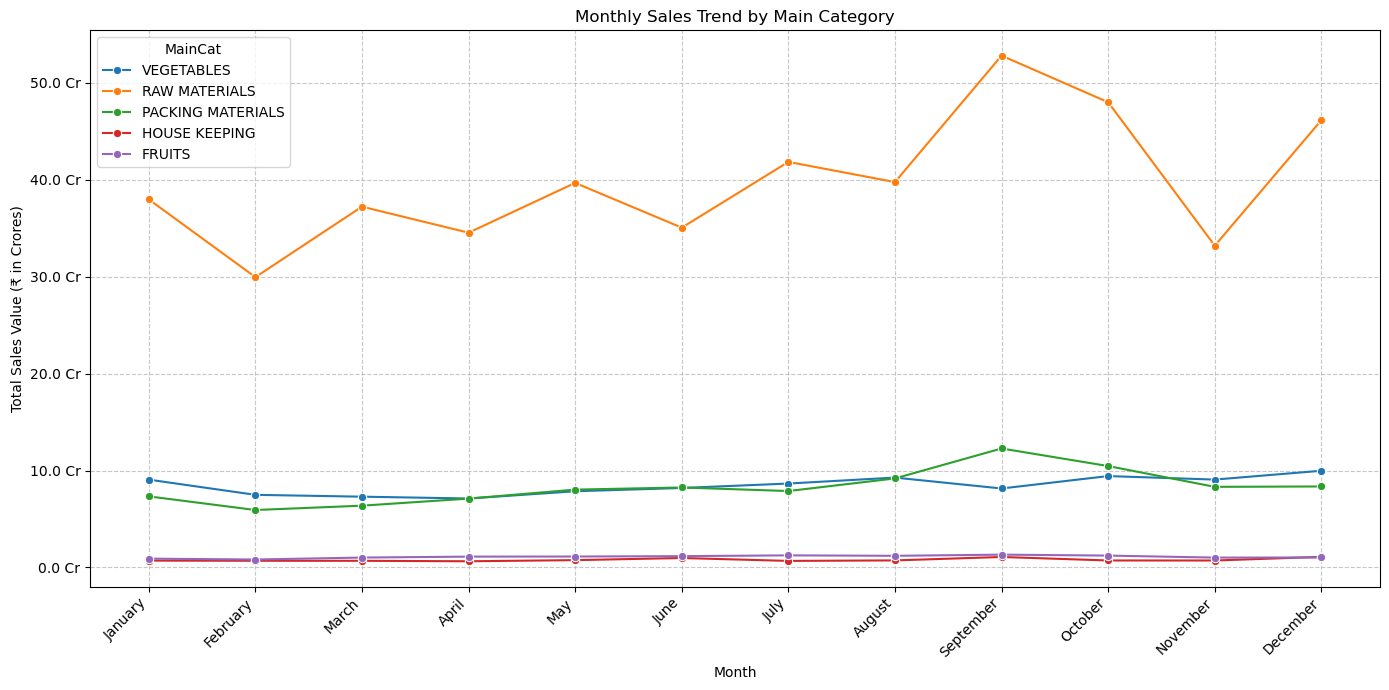

In [93]:
# Print Purchase Trend for various categories over the year

# Group by Month and MainCat to get total sales for each category per month
monthly_sales_by_category = df.groupby(['Month', 'MainCat'])['Value'].sum().reset_index()

# Create a dictionary to map month names to their numerical order
month_order_dict = {name: num for num, name in enumerate(calendar.month_name) if num}

# Map the month names to their numerical order for sorting
monthly_sales_by_category['Month_Num'] = monthly_sales_by_category['Month'].map(month_order_dict)

# Sort the DataFrame by Month_Num to ensure chronological order in the plot
monthly_sales_by_category = monthly_sales_by_category.sort_values(by='Month_Num')

plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_sales_by_category, x='Month', y='Value', hue='MainCat', marker='o')
plt.title('Monthly Sales Trend by Main Category')
plt.xlabel('Month')
plt.ylabel('Total Sales Value (₹ in Crores)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)

# Define a custom formatter for the y-axis to display in Crores
def crore_formatter(x, pos):
    return f'{x/10000000:,.1f} Cr'

# Apply the custom formatter to the y-axis
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(crore_formatter))

plt.tight_layout()
#plt.show()

# Prpearing Data for Report Generation
1. Divide df into dataframe associated with different categories
2. Performing ABC analysis for each category

In [94]:
# Create an empty dictionary to store the DataFrames
maincat_dfs_dict = {}

# Get unique MainCat values
unique_maincats = df['MainCat'].unique()

# Iterate through each unique MainCat and create a new DataFrame
for category in unique_maincats:
    df_category = df[df['MainCat'] == category].copy()
    # Dynamically name the DataFrame using the category name and store it in the dictionary
    maincat_dfs_dict[f'{category.replace(" ", "_")}'] = df_category

Created 5 DataFrames, one for each unique MainCat.
The keys of the dictionary are: ['FRUITS', 'VEGETABLES', 'RAW_MATERIALS', 'HOUSE_KEEPING', 'PACKING_MATERIALS']

# In the following code snippets, ready to use functions are created that are used subsequently

1. Function to assign produts to Groups A, B and C

In [95]:
# Assign products to ABC groups based on Cumulative_Percentage
def assign_abc_group(cumulative_percentage):
    if cumulative_percentage <= 85:
        return 'A'
    elif cumulative_percentage <= 95:
        return 'B'
    else:
        return 'C'

2. Function will return dataframe 'df_product_summary' with columns having statistical information

In [96]:
def get_product_statistics(df):
  df_product_summary = df.groupby('Product Name').agg(
    Total_Purchase_Amount=('Value', 'sum'),
    Total_Purchase_Quantity=('Qty', 'sum'),
    Mean_Rate=('Rate', 'mean'),
    Std_Rate=('Rate', 'std'),
    SubCat=('SubCat', 'first'), # Assuming SubCat is consistent for each product
    UOM=('UOM', 'first') # Assuming UOM is consistent for each product
).reset_index()

  # Calculate Coefficient of Variation
  df_product_summary['Coefficient_of_Variation_Rate'] = df_product_summary['Std_Rate'] / df_product_summary['Mean_Rate']

  # Sort the product_summary in descending order by 'Total_Purchase_Amount' and reset the index
  df_product_summary = df_product_summary.sort_values(by='Total_Purchase_Amount', ascending=False).reset_index(drop=True)

  # Adding Cumulative Sales, % on descending ordered list of product items
  total_rm_purchase = df_product_summary['Total_Purchase_Amount'].sum()
  df_product_summary['Cost_Percentage'] = (df_product_summary['Total_Purchase_Amount']/total_rm_purchase)*100
  df_product_summary['Cumulative_Amount'] = df_product_summary['Total_Purchase_Amount'].cumsum()
  df_product_summary['Cumulative_Percentage'] = (df_product_summary['Cumulative_Amount'] / total_rm_purchase) * 100

  df_product_summary['ABC_Group'] = df_product_summary['Cumulative_Percentage'].apply(assign_abc_group)

  return df_product_summary






3. Function will plot the no of items against its cumulative purchase contribution

In [97]:
def plot_cumulative_items_count_chart(df_name,df_product_summary):
  # Define cumulative thresholds
  thresholds = np.arange(5, 105, 5)

  # Count items with cumulative percentage <= each threshold
  counts = [
      (df_product_summary['Cumulative_Percentage'] <= t).sum()
      for t in thresholds
  ]

  # Plot
  plt.figure(figsize=(12, 6))
  plt.plot(thresholds, counts, marker='o')
  plt.xlabel('Cumulative Sales (%)')
  plt.ylabel('Number of Items')
  plt.title('Cumulative Item Count vs Cumulative Sales')
  plt.xticks(thresholds)
  plt.grid(True)

  # Data labels with vertical offset for spacing
  for x, y in zip(thresholds, counts):
      plt.annotate(
          str(y),
          (x, y),
          textcoords="offset points",
          xytext=(0, 8),   # vertical spacing
          ha='center'
      )



  plt.tight_layout()
  img_name = f'{df_name}_Cumulative_Item_Counts_Trend.png'
  #plt.savefig(img_name, dpi=300,bbox_inches='tight')

  output_dir = os.getcwd()+ '/Output/Images'
  os.makedirs(output_dir, exist_ok=True)
  image_path = os.path.join(output_dir, img_name)

  plt.savefig(image_path, dpi=300,bbox_inches='tight')

  #plt.show()
  plt.close()

  PAGE_WIDTH, PAGE_HEIGHT = portrait(A4)

  img = Image(image_path, width=500, height = 300)
  #img.drawWidth = PAGE_WIDTH - 80
  #img.drawHeight = PAGE_HEIGHT - 120

  return img


4. Function will plot the purchase trend for each main category

In [98]:
def plot_monthly_purchase_trend(df_name,df):
  # Group by Month to get total sales for Raw Materials per month
  # Use df_RAW_MATERIALS to focus on only the 'RAW MATERIALS' category
  monthly_sales = df.groupby(['Month'])['Value'].sum().reset_index()

  # Create a dictionary to map month names to their numerical order
  month_order_dict = {name: num for num, name in enumerate(calendar.month_name) if num}

  # Map the month names to their numerical order for sorting
  monthly_sales['Month_Num'] = monthly_sales['Month'].map(month_order_dict)

  # Sort the DataFrame by Month_Num to ensure chronological order in the plot
  monthly_sales = monthly_sales.sort_values(by='Month_Num')

  plt.figure(figsize=(14, 7))
  # Remove hue='MainCat' as we are plotting the total for Raw Materials
  sns.lineplot(data=monthly_sales, x='Month', y='Value', marker='o')
  plt.title(f'Monthly Purchase Trend for {df_name} Category')
  plt.xlabel('Month')
  plt.ylabel('Total Purchase Value (₹ in Crores)')
  plt.xticks(rotation=45, ha='right')
  plt.grid(True, linestyle='--', alpha=0.7)

  # Define a custom formatter for the y-axis to display in Crores
  def crore_formatter(x, pos):
      return f'{x/10000000:,.1f} Cr'

  # Apply the custom formatter to the y-axis
  plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(crore_formatter))

  # Add data labels for each point
  for index, row in monthly_sales.iterrows():
      plt.annotate(
          f'{row["Value"]/10000000:,.1f} Cr', # Format value to Crores
          (row['Month'], row['Value']), # x, y coordinates
          textcoords="offset points", # How to position the text
          xytext=(0,10), # Distance from text to points (x,y)
          ha='center', # Horizontal alignment
          fontsize=9
      )

  plt.tight_layout()

  img_name = f'{df_name}_Monthly_Purchase_Trend.png'


  output_dir = os.getcwd() + '/Output/Images'
  os.makedirs(output_dir, exist_ok=True)
  image_path = os.path.join(output_dir, img_name)

  plt.savefig(image_path, dpi=300,bbox_inches='tight')

  #plt.show()
  plt.close()

  PAGE_WIDTH, PAGE_HEIGHT = portrait(A4)

  img = Image(image_path, width=500, height = 300)
  #img.drawWidth = PAGE_WIDTH - 80
  #img.drawHeight = PAGE_HEIGHT - 120

  return img



5. Function will select only group A products and sort them based on sub category and annual purchase amount

In [99]:
def get_groupA_product_summary(df_product_summary):
  # Prepare data for selecting only Group A product items
  df_product_summary_group_A = (
      df_product_summary[df_product_summary['ABC_Group'] == 'A']
      .sort_values(by=['SubCat', 'Total_Purchase_Amount'],
                  ascending=[True, False])
  )
  return df_product_summary_group_A

6. Function will return pdf doc 

In [100]:
def createPdfFileDirectory(df_name):
    # File name
    pdf_file = f"{df_name}.pdf"

    report_output_dir = os.getcwd() + '/Output/Report'
    os.makedirs(report_output_dir, exist_ok=True)

    pdf_path = os.path.join(report_output_dir, pdf_file)

    # Create document
    doc = SimpleDocTemplate(
        pdf_path,
        pagesize=portrait(A4),
        leftMargin=36,    # 0.5 inch
        rightMargin=36,   # 0.5 inch
        topMargin=36,
        bottomMargin=36
        )

    return doc

7. Function will return title for the document based on the category

In [101]:
def getDocTitle(df_name):
    # Creating title Style
    titleStyle = ParagraphStyle(
        name='TitleStyle',
        fontName='Helvetica-Bold',
        fontSize=18,
        alignment=TA_CENTER,
        spaceAfter=20
    )
    return Paragraph(f"Purchase Data Analysis: <b>{escape(df_name)}</b>", titleStyle)

8. Function will return details - Analysis Period, No of unique items in the category, annual purchase for category

In [102]:
def getFirstHeader(df_name, df_product_summary):
  item_count = df_product_summary['Product Name'].nunique()
  total_annual_purchase = df_product_summary['Total_Purchase_Amount'].sum()
  total_annual_purchase_cr =  f"{total_annual_purchase / 1e7:.0f} Cr"

  styles = getSampleStyleSheet()


  first_header = Paragraph(
          f"Analysis Period: <b>Jan - Dec 2025</b> &nbsp;&nbsp; | &nbsp;&nbsp; "
          f"No of Unique Items Purchased: <b>{item_count}</b>&nbsp;&nbsp; | &nbsp;&nbsp; "
          f"Total Annual Purchase: <b>INR {total_annual_purchase_cr}</b>",
          styles['Normal']
          )

  return first_header


9. Function will return details - Group A Items, Group B Items, Group C Items

In [103]:
def getSecondHeader(df_name, df_product_summary):

  group_A_count = len(df_product_summary[df_product_summary['ABC_Group']=="A"])
  group_B_count = len(df_product_summary[df_product_summary['ABC_Group']=="B"])
  group_C_count = len(df_product_summary[df_product_summary['ABC_Group']=="C"])

  styles = getSampleStyleSheet()

  second_header = Paragraph(
          f"Items in Group A (top 85%): <b>{group_A_count}</b> &nbsp;&nbsp; | &nbsp;&nbsp; "
          f"Items in Group B (85% - 95%): <b>{group_B_count}</b>&nbsp;&nbsp; | &nbsp;&nbsp; "
          f"Items in Group C (95% - 100%): <b>{group_C_count}</b>",
          styles['Normal']
          )

  return second_header

10. Function will return table header based on the category name

In [104]:
def getTableHeader(df_name, df_product_summary):
  styles = getSampleStyleSheet()
  styles.alignment = TA_CENTER
  group_A_count = len(df_product_summary[df_product_summary['ABC_Group']=="A"])
  table_header = Paragraph(
        f'Analysis of top {group_A_count} items from {df_name} category',
        styles['Normal'] )
  return table_header


11. Function will populate the table data 

In [105]:
def getTableValues(df_product_summary_groupA):
  styles = getSampleStyleSheet()

  # Adding two header rows
  header_row_1 = [
      Paragraph('Product Name',styles['Heading4']),
      Paragraph('Total Purchase<br/>INR Cr',styles['Heading4']),
      Paragraph('Total Purchase<br/>QTY',styles['Heading4']),
      Paragraph('UOM',styles['Heading4']),
      Paragraph('Cost %',styles['Heading4']),
      Paragraph('Per Unit Rate Statistics', styles['Heading4']),
      '',
      '']

  header_row_2 = [
      '',
      '',
      '',
      '',
      '',
      Paragraph('Avg Rate<br/>(INR)',styles['Normal']),
      Paragraph('Std Dev',styles['Normal']),
      Paragraph('Coef of<br/>Variation<br/>',styles['Normal'])
      ]

  table_data = []
  # Add header rows first (if any)
  table_data.append(header_row_1)
  table_data.append(header_row_2)

  current_subcat = None
  subcat_row_indices = []

  #style_table_paragraph_column =
  style_table_paragraph_column = ParagraphStyle(
    name='CustomStyle',
    fontName='Helvetica',
    fontSize=9,
    #leading=11,  # line spacing (important!)
)


  for row in df_product_summary_groupA.values.tolist():

    subcat = row[5]

    # If new subcategory, insert header row
    if subcat != current_subcat:
        subcat_row_indices.append(len(table_data))
        table_data.append([
            Paragraph(f"<b>{subcat}</b>", styles["Normal"]),
            "", "", "", "", "", "", ""
        ])
    current_subcat = subcat

    table_data.append([
        Paragraph(str(row[0]),style_table_paragraph_column),                   # Iname
        f"{row[1] / 1e7:.2f}",                                     # Amount in Cr (2 decimals)
        f"{row[2]:,.2f}",                                          # Total Purchase Qty
        Paragraph(str(row[6]),style_table_paragraph_column),                   # UOM
        f"{row[8]:.2f}",                                           # Cost %
        f"{row[3]:.2f}",                                           # Avg Rate
        f"{row[4]:.2f}",                                           # Std Dev
        f"{row[7]:.2f}"                                            # Coeff of Variation

    ])
  return table_data, subcat_row_indices


12. Function provide the formatting for table

In [106]:
def getMainTableStyle(df_product_summary_groupA, subcat_row_indices):
  # Styling
  table_style = [
      ('SPAN', (0, 0), (0, 1)),
      ('SPAN', (1, 0), (1, 1)),
      ('SPAN', (2, 0), (2, 1)),
      ('SPAN', (3, 0), (3, 1)),
      ('SPAN', (4, 0), (4, 1)),
      ('SPAN', (5, 0), (7, 0)),


      #Header FORMATTING

      ('BACKGROUND', (0, 0), (-1, 1), colors.lightgrey),
      ('TEXTCOLOR', (0, 1), (-1, -1), colors.black),

      ('FONT', (0, 0), (-1, 0), 'Helvetica-Bold'),
      ('ALIGN', (1, 1), (-1, 1), 'CENTER'),
      ('VALIGN', (0, 0), (-1, -1), 'MIDDLE'),
      ('WORDWRAP', (0, 0), (-1, -1), 'CJK'),

      # Font size for rows 3 to 11 (0-indexed → rows 2 to 10)
      ('FONTSIZE', (0, 2), (-1, -1), 9),

      # Center alignment for rows 3 to 11
      ('ALIGN', (0, 2), (-1, -1), 'CENTER'),
      ('VALIGN', (0, 2), (-1, -1), 'MIDDLE'),


      #Body Formatting
      ('GRID', (0, 0), (-1, -1), 0.5, colors.black),
      ('ALIGN', (1, 2), (-1, -1), 'RIGHT'),
      ]

  for idx in subcat_row_indices:
      table_style.append(('SPAN', (0, idx), (-1, idx)))
      table_style.append(('BACKGROUND', (0, idx), (-1, idx), colors.lightyellow))

  return table_style


13. Function will return table with formatted data

In [107]:
def getMainTable(df_product_summary_groupA,doc):
  page_width, page_height = portrait(A4)
  usable_width = page_width - doc.leftMargin - doc.rightMargin
  col_width_ratios = [3.2,  # itemName
          1.6,  # Total Purchase (INR)
          1.6,  # Total Purchase Qty
          1.0,  # UOM
          1.2,  # Cost %
          1.2,  # Average Rate
          1.2,  # Std Dev
          1.2]   # Coeff of Variation (%)]
  total_ratio = sum(col_width_ratios)
  col_widths = [(r / total_ratio) * usable_width for r in col_width_ratios]

  table_data, subcat_row_indices = getTableValues(df_product_summary_groupA)
  table = Table(table_data, colWidths=col_widths,repeatRows=2)

  table_style = getMainTableStyle(df_product_summary_groupA, subcat_row_indices)
  table.setStyle(TableStyle(table_style))


  return table

14. Function build the pdf document 

In [108]:
def generate_pdf_report(df_name,df):

  df_product_summary =  get_product_statistics(df)

  df_product_summary_groupA = get_groupA_product_summary(df_product_summary)

  doc = createPdfFileDirectory(df_name)

  elements = []

  elements.append(getDocTitle(df_name))

  elements.append(getFirstHeader(df_name, df_product_summary))

  elements.append(Spacer(1, 12))

  elements.append(getSecondHeader(df_name, df_product_summary))

  elements.append(Spacer(1, 12))

  elements.append(plot_cumulative_items_count_chart(df_name,df_product_summary))

  elements.append(Spacer(1, 16))

  elements.append(plot_monthly_purchase_trend(df_name,df))

  elements.append(Spacer(1, 16))

  elements.append(PageBreak())

  elements.append(getTableHeader(df_name, df_product_summary))

  elements.append(Spacer(1, 12))

  elements.append(getMainTable(df_product_summary_groupA,doc))

  doc.build(elements)




15. Below code surve as main function. It will iterate over the category data frames created earlier and publish the pdf report. 

In [109]:
for df_name, df in maincat_dfs_dict.items():
    generate_pdf_report(df_name, df)